# Hackathon: The AED Challenge

Our Hackathon project focus on Annotation Error Detection (AED) for machine learning datasets. The goal is to identify and correct errors in the annotations of datasets used for training machine learning models.



## 🎯 Goals

Your goal is to build an automated method to detect incorrectly labeled images in a **training dataset**. You will be evaluated on how many label errors you can correctly identify.



## 📁 Datasets

You will be provided with two main datasets:

1.  **Training Set (`training_set`)**
    *   **Contents**: A collection of images and their corresponding labels.
    *   **The Catch**: This set contains an unknown number of labeling errors. You **do not** have the ground truth for which labels are incorrect.
    *   **Your Goal**: This is the dataset you must analyze. Your final submission will be a list of suspected errors from this set.

2.  **Validation Set (`validation_set`)**
    *   **Contents**: A smaller collection of images, their labels, and a special ground truth column (`is_noisy`).
    *   **Purpose**: This set is your sandbox. You can use it to develop, test, and validate your error detection models and algorithms. The `is_noisy` column will tell you exactly which labels are wrong (`1`) and which are correct (`0`), allowing you to measure your method's performance before applying it to the real challenge.

The original dataset comes from [this hackathon](https://https-deeplearning-ai.github.io/data-centric-comp/) by Andrew Ng and the Deeplearning.ai team.


## 📝 Your Task

1.  **Explore the Data**: Start by analyzing both the `training_set` and `validation_set`. Understand the classes, image characteristics, and potential sources of error.
2.  **Develop Your Method**: Use the `validation_set` to build and refine your strategy. You could train a model and look for low-confidence predictions, analyze feature embeddings to find outliers, or use other clever techniques.
3.  **Identify Errors in the Training Set**: Once you are confident in your method, apply it to the `training_set` to predict which items have incorrect labels.
4.  **Generate a Submission File**: Create a CSV file detailing your findings.



## 🚀 Submission

Your final output must be a single CSV file named `submission.csv`. This file will be uploaded to the online judging platform.

For your grades,  you'll also need to upload your work to a GitHub repository. The repository should include:
-   Your code for the error detection method.
-   A README file explaining your approach, how to run your code, and any dependencies.
-   Any additional files or scripts that are necessary to reproduce your results.

## 📅 Timeline
-   **Start Time**: 2025-06-26 - 19:00
-   **End Time**: 2025-06-26 - 21:30
-   **Submission Deadline**: 2025-06-26 - 21:30
-   **SIGAA Submission Deadline**: 2025-06-27 - 23:59



### Submission File Format

The CSV file must contain exactly two columns: `uid` and `is_noisy`.

*   `uid`: The identifier/filename of the image from the `training_set`.
*   `is_noisy`: Your prediction. Use `1` if you believe the label is an error, and `0` if you believe it is correct.

**Example `submission.csv`:**

```csv
uid,is_noisy
12345676890aed,0
12345676890aee,1
12345676890aef,0
12345676890af0,1
...
```



## 🏆 Evaluation

Your submission will be evaluated using the **Matthews Correlation Coefficient (MCC)**.

*   **Why MCC?**: MCC is a robust metric for binary classification that performs well even when the classes are highly imbalanced (as we expect far more correct labels than incorrect ones). It provides a single, balanced score that accounts for true/false positives and negatives.
*   **The Winner**: The team with the highest MCC score on the hidden ground truth of the `training_set` wins!
*   **Your Grade**: Your grade will be based on the quality of your submission on SIGAA.

The final **leaderboard** on the platform will show your rank and score after each submission.


In [1]:
!pip install transformers
!pip install Pillow
!pip install numpy
!pip install joblib
!pip install pathlib
!pip install tqdm
!pip install cleanlab[datalab]
!pip install matplotlib
!pip install plotly
!pip install xgboost
!pip install cleanvision
!pip install seaborn
!pip install --extra-index-url https://download.pytorch.org/whl/cu128
!pip install torch
!pip install torchvision
!pip install torchaudio
!pip install transformers[torch]

ERROR: You must give at least one requirement to install (see "pip help install")


In [2]:
import pandas as pd
import requests
import io
# Download the dataset from the provided URL
url_train = 'https://public.jacob.al/imd3011-datacentric_ai/hackathon-2025-2/train_no_labels.json.gz'
url_valid = 'https://public.jacob.al/imd3011-datacentric_ai/hackathon-2025-2/valid.json.gz'

response_train = requests.get(url_train)
response_valid = requests.get(url_valid)

# Read the JSON data into pandas DataFrames
train_data = pd.read_json(io.BytesIO(response_train.content), compression='gzip')
valid_data = pd.read_json(io.BytesIO(response_valid.content), compression='gzip')


In [3]:
train_data

,image,label,uid
0,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",I,32e9d51d-8a22-4f97-9955-8f9647a7f13c
1,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",VII,a7c9faf9-a7e2-4687-a57b-ac0558ccee8b
2,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",II,0baccef4-de79-4f71-b7ec-c77cc2ab9e50
3,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",IX,81fe9a13-d0fe-43ad-8185-c59ea6117cce
4,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",II,92e3b890-c9ab-4e9c-a63b-ad42de92e5a2
...,...,...,...
2401,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",IX,f585b600-175d-4709-a00a-5e608be22d93
2402,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",I,caa40a00-e396-4d0b-9893-4b51a7a8d205
2403,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",V,f690990e-1d3a-48e7-92de-6bb7769e1f9a
2404,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",VIII,2f06f8a6-64d1-411f-8482-b69e61c94c82


In [5]:
valid_data

,image,label,is_noisy,uid
0,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",II,0,d58ccd8d-65b1-4f7d-914b-50ce98c1bbeb
1,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",V,0,ecccff0d-f2c1-479d-9703-ce18b1635ceb
2,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",III,0,e04c4f02-0a19-4020-a028-e2ed56d2f081
3,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",X,0,c0d36cb6-9914-44d4-b7d6-2460cbb599fb
4,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",I,0,5dfbdf79-2474-44fb-8942-096a3731b4be
...,...,...,...,...
420,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",VIII,1,2e631889-a3b1-44bb-bed5-de33897f129d
421,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",III,1,6c97f1f5-de71-4773-ab03-b5e36239cd90
422,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",VII,0,22c6e775-4729-4eb9-bfea-376031e07611
423,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",II,0,b636e6dd-a697-471c-b4f1-77a9006fade8


In [6]:
len(valid_data[valid_data.is_noisy == True])

56

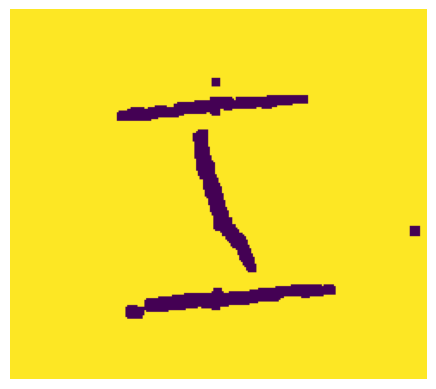

In [7]:
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np

def show_image_from_np_array(np_array):
    np_array = np.array(np_array, dtype=np.uint8)  # Ensure the array is in the correct format
    image = Image.fromarray(np_array)
    plt.imshow(image)
    plt.axis('off')  # Hide the axis
    plt.show()

# Display the first image from the training dataset
show_image_from_np_array(train_data['image'][0])

In [8]:
valid_data.query('is_noisy == True').head(5)

,image,label,is_noisy,uid
8,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",VIII,1,c0b72cc4-6c08-4814-b577-212bea7f763b
22,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",III,1,b913a1f0-f93b-406f-a662-02cee36aab76
28,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",VII,1,89767360-1f14-4cf0-b600-4177cc9c05dd
29,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",II,1,419a9f54-7505-4733-b8de-da40a63dda9c
34,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",V,1,1429c7a4-9b9b-40bc-b2f7-9642df383894


In [9]:
train_data.label.value_counts()

label
IV      304
I       282
IX      260
VIII    246
V       242
III     225
VI      222
VII     221
X       208
II      196
Name: count, dtype: int64

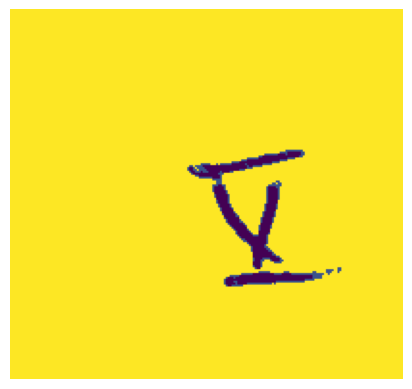

X


In [10]:
row = valid_data.query('is_noisy == True').sample(1).iloc[0]

show_image_from_np_array(row['image'])
print(row['label'])


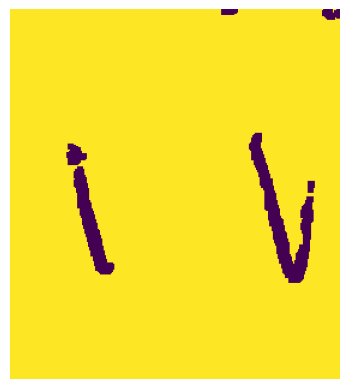

VI


In [11]:
row = valid_data.query('is_noisy == True').sample(1).iloc[0]

show_image_from_np_array(row['image'])
print(row['label'])


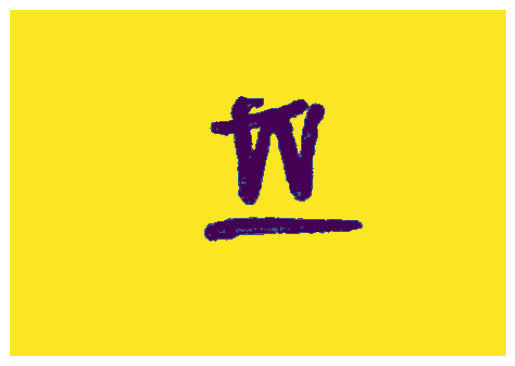

IV


In [61]:
row = valid_data.query('is_noisy == True').sample(1).iloc[0]

show_image_from_np_array(row['image'])
print(row['label'])


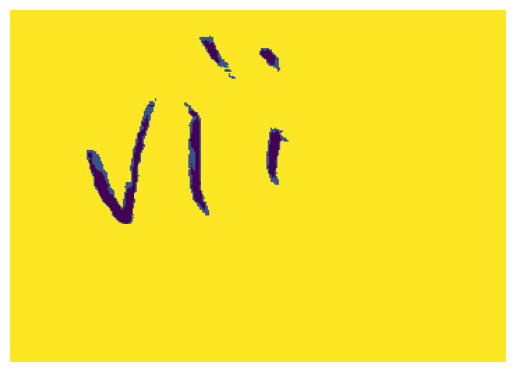

VII


In [62]:
row = valid_data.query('is_noisy == True').sample(1).iloc[0]

show_image_from_np_array(row['image'])
print(row['label'])


In [63]:
max_length = max(train_data['image'].apply(len))
print(max_length)

616


In [64]:
TARGET_SIZE = 648  # Next multiple of 3 × pixels (216)
IMG_SHAPE = (18, 12)  # (H, W) such that H × W = 216


In [65]:
from transformers import AutoImageProcessor, AutoModel
from PIL import Image
import torch
import numpy as np
from tqdm import tqdm

# Load processor and model
processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
model = AutoModel.from_pretrained("google/vit-base-patch16-224-in21k")

TARGET_SIZE = 648  # Must be divisible by 3
IMG_SHAPE = (18, 12)  # So that 18 * 12 * 3 = 648

def extract_embedding_from_pixels(pixel_lists):
    embeddings = []
    for i, pixels in enumerate(tqdm(pixel_lists)):
        try:
            # Convert the list of pixels to a NumPy array first
            # This is crucial if 'pixels' is a list of lists or has nested structures
            pixels_array = np.array(pixels, dtype=np.uint8)

            # Ensure the array is flattened to the expected TARGET_SIZE
            # Handle cases where the original pixel data might be shorter or longer
            if pixels_array.size < TARGET_SIZE:
                # Pad with zeros if shorter
                pixels_array = np.pad(pixels_array, (0, TARGET_SIZE - pixels_array.size), 'constant')
            elif pixels_array.size > TARGET_SIZE:
                # Truncate if longer (though padding should ideally handle this)
                pixels_array = pixels_array[:TARGET_SIZE]

            # Reshape to the expected image shape (H, W, C)
            # Ensure the number of elements is exactly TARGET_SIZE before reshaping
            if pixels_array.size != TARGET_SIZE:
                 # If it's still not the correct size, try to flatten and pad again
                 # This is a fallback, the above padding should ideally fix it
                 pixels_array = np.array(pixels, dtype=np.uint8).flatten()
                 if pixels_array.size < TARGET_SIZE:
                     pixels_array = np.pad(pixels_array, (0, TARGET_SIZE - pixels_array.size), 'constant')
                 else:
                     pixels_array = pixels_array[:TARGET_SIZE]


            # Now reshape, ensuring it's compatible with (H, W, C)
            # This assumes the flattened array has TARGET_SIZE elements
            reshaped_array = pixels_array.reshape((*IMG_SHAPE, 3))

            # Convert NumPy array to PIL Image
            img = Image.fromarray(reshaped_array, mode="RGB")

            # Resize to ViT's expected input size (224x224)
            img = img.resize((224, 224))

            # Process through model
            inputs = processor(images=img, return_tensors="pt")
            with torch.no_grad():
                outputs = model(**inputs)
            feature_vector = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()
            embeddings.append(feature_vector)

        except ValueError as ve:
            print(f"ValueError at index {i}: {ve}. Pixels array shape: {pixels_array.shape if 'pixels_array' in locals() else 'N/A'}")
            # Append a zero vector if an error occurs (e.g., for images that can't be processed)
            embeddings.append(np.zeros(model.config.hidden_size))
        except Exception as e:
            print(f"General error at index {i}: {e}")
            embeddings.append(np.zeros(model.config.hidden_size))  # fallback

    return np.array(embeddings)

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


In [66]:
train_embeddings = extract_embedding_from_pixels(train_data['image'])

100%|██████████| 2406/2406 [11:08<00:00,  3.60it/s]


In [67]:
train_embeddings

array([[-0.07940922,  0.19458538, -0.0495496 , ...,  0.10575833,
         0.01385066,  0.13288431],
       [-0.07940922,  0.19458538, -0.0495496 , ...,  0.10575833,
         0.01385066,  0.13288431],
       [-0.07940922,  0.19458538, -0.0495496 , ...,  0.10575833,
         0.01385066,  0.13288431],
       ...,
       [-0.07940922,  0.19458538, -0.0495496 , ...,  0.10575833,
         0.01385066,  0.13288431],
       [-0.07940922,  0.19458538, -0.0495496 , ...,  0.10575833,
         0.01385066,  0.13288431],
       [-0.07940922,  0.19458538, -0.0495496 , ...,  0.10575833,
         0.01385066,  0.13288431]], dtype=float32)

In [68]:
val_embeddings = extract_embedding_from_pixels(valid_data['image'])

100%|██████████| 425/425 [02:25<00:00,  2.92it/s]


In [69]:
X_train = train_embeddings
y_train = train_data.label

X_valid = val_embeddings
y_valid = valid_data.label

In [70]:
X_valid.shape, y_valid.shape

((425, 768), (425,))

In [71]:
y_valid

0        II
1         V
2       III
3         X
4         I
       ... 
420    VIII
421     III
422     VII
423      II
424       X
Name: label, Length: 425, dtype: object

In [72]:
class_names = y_train.unique().tolist()

# 2. Create the class_to_idx dictionary
# This uses a dictionary comprehension to iterate through the unique class names.
# `enumerate` provides both the index (i) and the value (name) for each item.
class_to_idx = {name: i for i, name in enumerate(class_names)}

# 3. Create the idx_to_class dictionary
# This is the inverse of the class_to_idx dictionary.
# We can create it by swapping the keys and values from class_to_idx.
idx_to_class = {i: name for name, i in class_to_idx.items()}

In [73]:
idx_to_class

{0: 'I',
 1: 'VII',
 2: 'II',
 3: 'IX',
 4: 'VIII',
 5: 'VI',
 6: 'III',
 7: 'V',
 8: 'IV',
 9: 'X'}

In [74]:
train_data.label.value_counts()

label
IV      304
I       282
IX      260
VIII    246
V       242
III     225
VI      222
VII     221
X       208
II      196
Name: count, dtype: int64

In [75]:
train_data['class_idx'] = train_data['label'].map(class_to_idx)

In [76]:
train_data.class_idx.value_counts()

class_idx
8    304
0    282
3    260
4    246
7    242
6    225
5    222
1    221
9    208
2    196
Name: count, dtype: int64

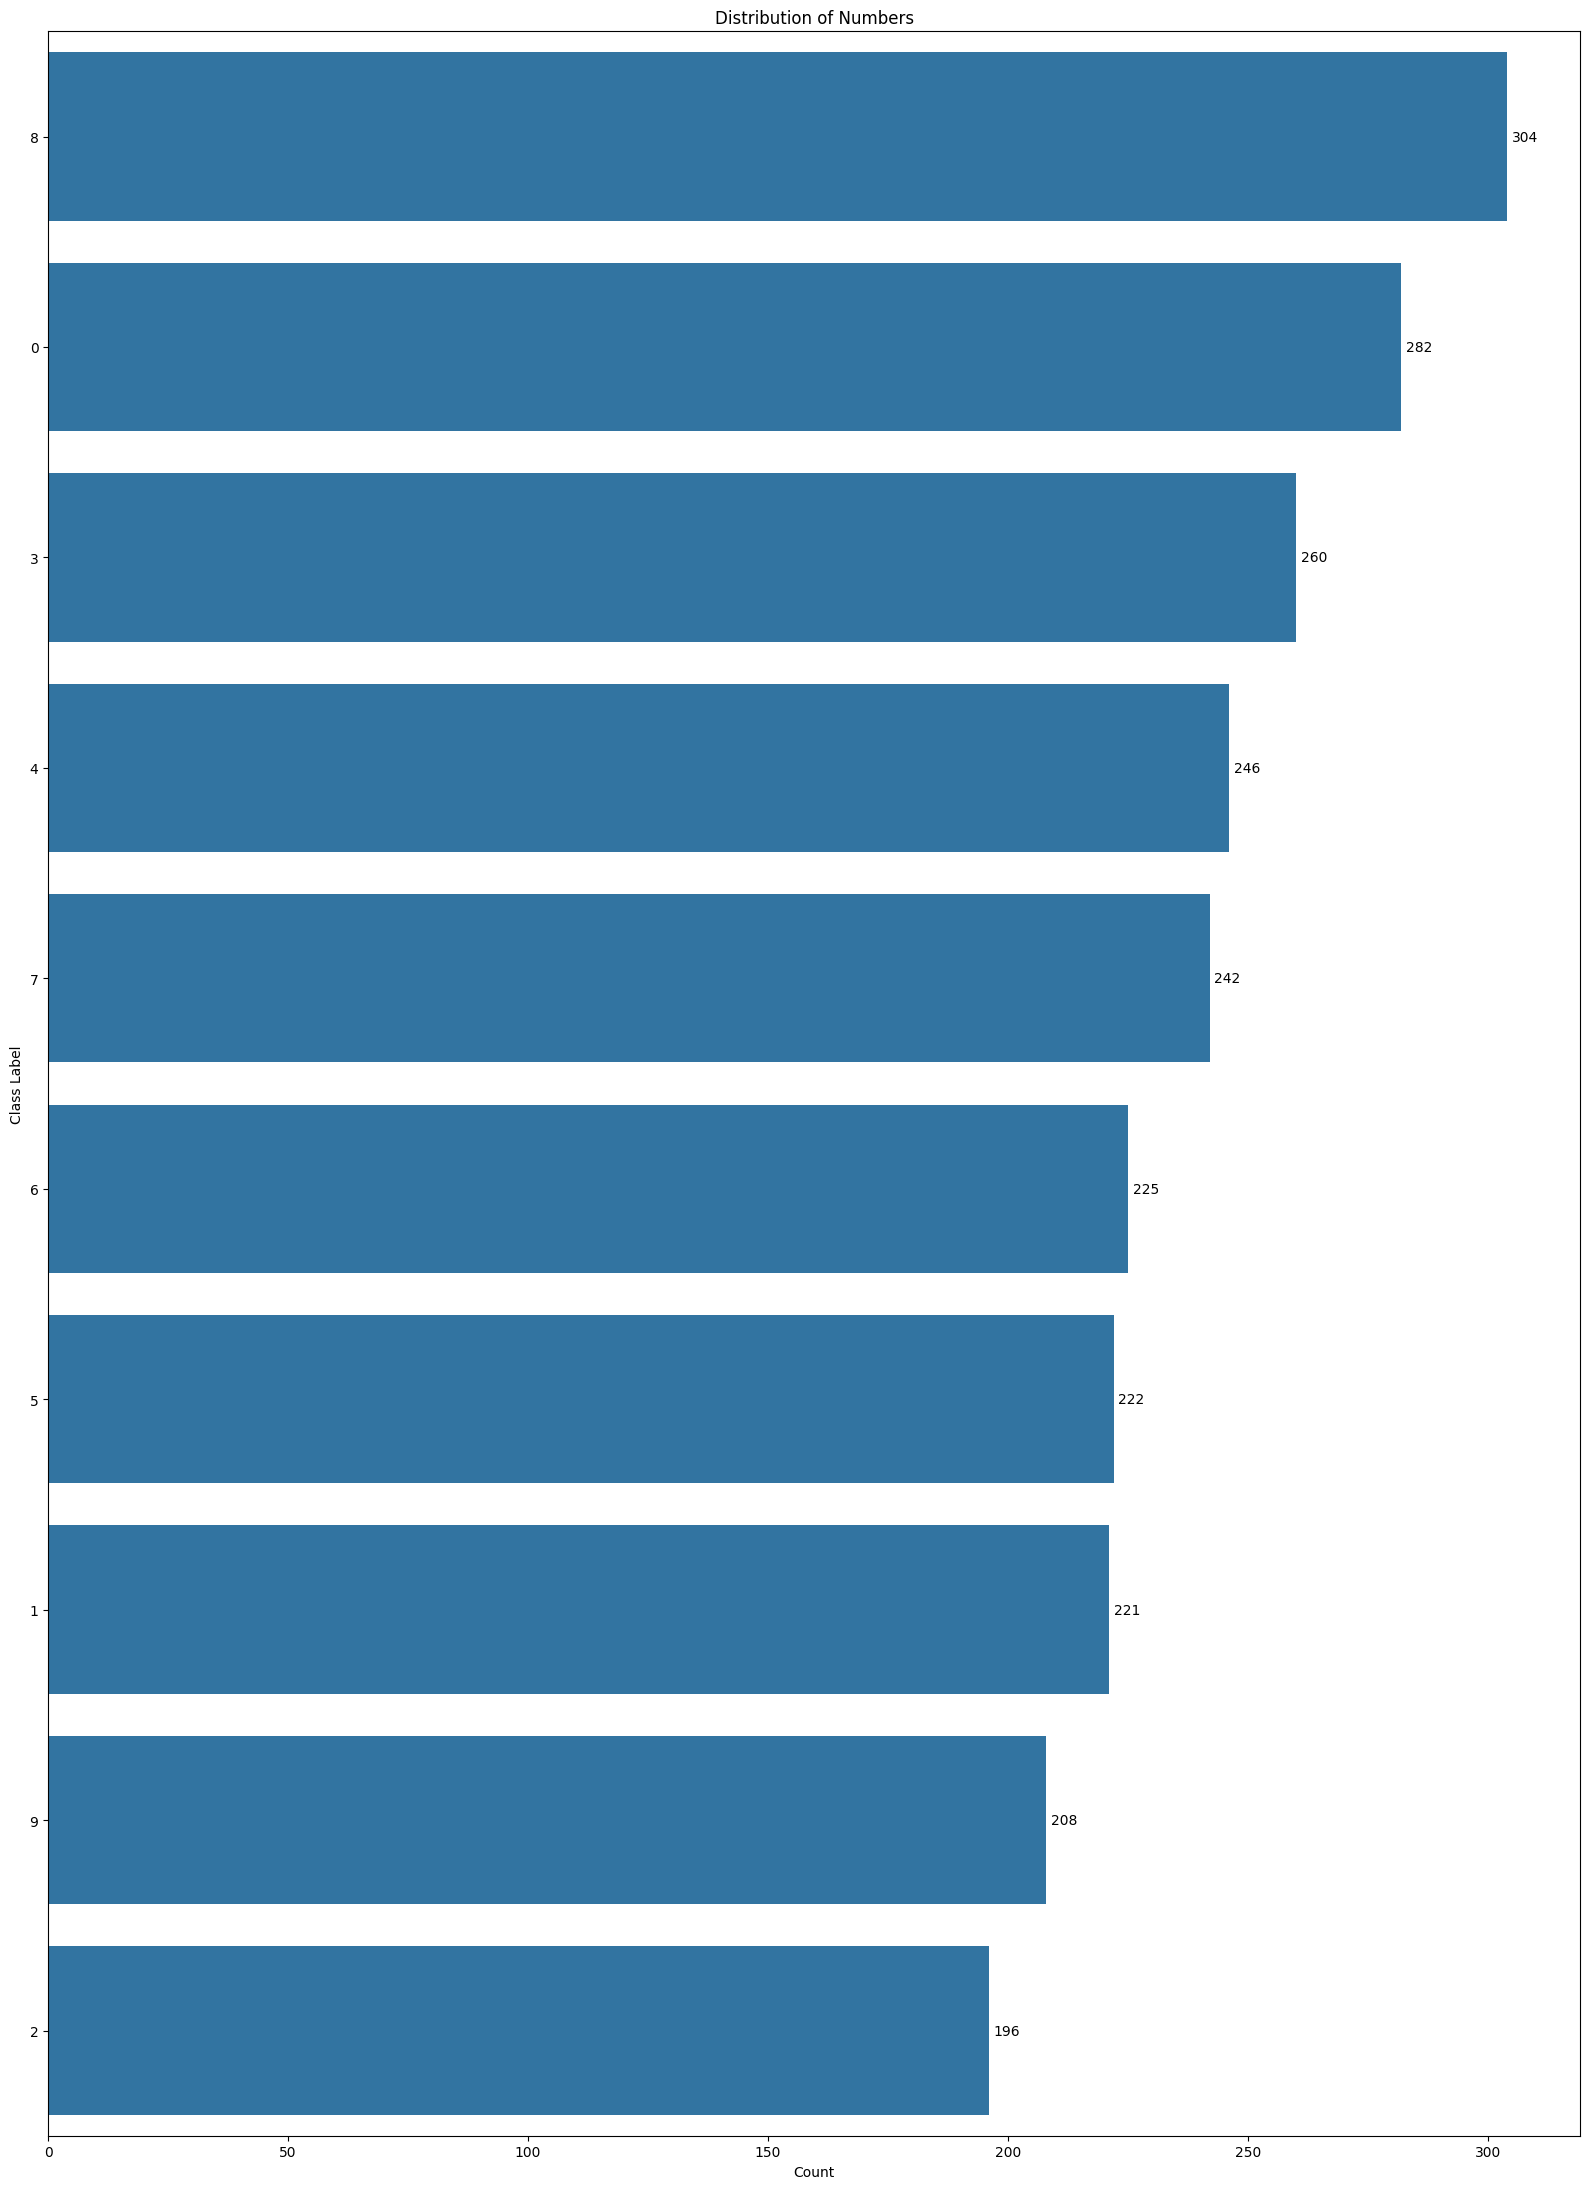

In [77]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16, 22))
ax = sns.countplot(y=train_data['class_idx'], order=train_data['class_idx'].value_counts().index)
plt.xlabel('Count')
plt.ylabel('Class Label')
plt.title('Distribution of Numbers')

for p in ax.patches:
    width = p.get_width()    
    plt.text(width + 1,       
             p.get_y() + p.get_height()/2., ## Add the number of instances for each class after the bar 
             f'{int(width)}', 
             ha='left',       
             va='center')

plt.tight_layout()
plt.show()

In [78]:
# Import the Datalab class from the cleanlab library
from cleanlab import Datalab

# Create a Datalab object with the training data with no label name
lab = Datalab(data=train_data)

# Use the Datalab object to find issues  with the features (we are not using predicted probabilities, thus, not analysing label issues so far)
lab.find_issues(features=X_train, issue_types={"near_duplicate": {}, "outlier": {}})

# Generate a report of the issues found by the Datalab object
lab.report()

Finding near_duplicate issues ...
Finding outlier issues ...

Audit complete. 2406 issues found in the dataset.
Dataset Information: num_examples: 2406

Here is a summary of various issues found in your data:

    issue_type  num_issues
near_duplicate        2166
       outlier         240

Learn about each issue: https://docs.cleanlab.ai/stable/cleanlab/datalab/guide/issue_type_description.html
See which examples in your dataset exhibit each issue via: `datalab.get_issues(<ISSUE_NAME>)`

Data indices corresponding to top examples of each issue are shown below.


------------------ near_duplicate issues -------------------

About this issue:
	A (near) duplicate issue refers to two or more examples in
    a dataset that are extremely similar to each other, relative
    to the rest of the dataset.  The examples flagged with this issue
    may be exactly duplicated, or lie atypically close together when
    represented as vectors (i.e. feature embeddings).
    

Number of examples with th

In [79]:
# Retrieve the near-duplicate issues identified by the Datalab object
# Filter the issues to only include those marked as actual near-duplicate issues
near_duplicates = lab.get_issues("near_duplicate").query("is_near_duplicate_issue == True")

# Retrieve the outlier issues identified by the Datalab object
# Filter the issues to only include those marked as actual outlier issues
outliers = lab.get_issues("outlier").query("is_outlier_issue == True")

# Display the DataFrame containing the near-duplicate issues
near_duplicates

,is_near_duplicate_issue,near_duplicate_score,near_duplicate_sets,distance_to_nearest_neighbor
0,True,0.0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 12, 14, 15, 17, 18...",0.0
1,True,0.0,"[0, 2, 3, 4, 5, 6, 7, 8, 9, 12, 14, 15, 17, 18...",0.0
2,True,0.0,"[0, 1, 3, 4, 5, 6, 7, 8, 9, 12, 14, 15, 17, 18...",0.0
3,True,0.0,"[0, 1, 2, 4, 5, 6, 7, 8, 9, 12, 14, 15, 17, 18...",0.0
4,True,0.0,"[0, 1, 2, 3, 5, 6, 7, 8, 9, 12, 14, 15, 17, 18...",0.0
...,...,...,...,...
2401,True,0.0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]",0.0
2402,True,0.0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]",0.0
2403,True,0.0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]",0.0
2404,True,0.0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]",0.0


In [80]:
# Sort the outliers DataFrame by the 'outlier_score' column in ascending order
# This helps in identifying the most significant outliers first
outliers = outliers.sort_values("outlier_score", ascending=True)

# Display the sorted outliers DataFrame
outliers

,is_outlier_issue,outlier_score
10,True,0.0
1431,True,0.0
1439,True,0.0
1440,True,0.0
1442,True,0.0
...,...,...
848,True,0.0
860,True,0.0
861,True,0.0
2371,True,0.0


In [ ]:
NUMBER = 1431

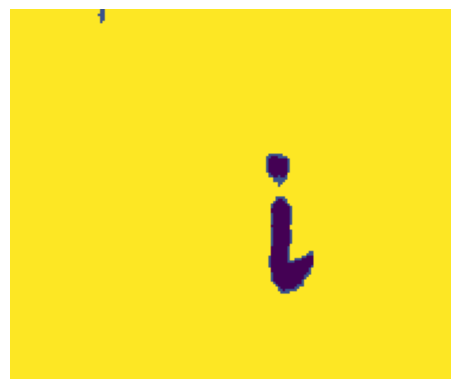

In [ ]:
show_image_from_np_array(train_data['image'][1431])

In [ ]:
train_data.iloc[1431]

image        [[255, 255, 255, 255, 255, 255, 255, 255, 255,...
label                                                        I
uid                       28557544-1c57-4e8a-8162-4fd0d2f82af4
class_idx                                                    0
Name: 10, dtype: object

In [84]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.base import clone

def recov(X, y, model, n_runs=100, k_folds=5, random_state=None):
    n_samples = len(X)
    occurrence_counts = np.zeros(n_samples)
    
    for run in range(n_runs):
        kf = KFold(n_splits=k_folds, shuffle=True, random_state=random_state + run if random_state is not None else None)
        fold_val_scores = []
        fold_indices = []
        
        models = []
        for train_idx, val_idx in kf.split(X):
            X_train, X_val = X[train_idx], X[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]
            
            fold_model = clone(model)
            fold_model.fit(X_train, y_train)
            models.append(fold_model)
            fold_indices.append(val_idx)
            
            score = fold_model.score(X_val, y_val)
            fold_val_scores.append(score)
        
        worst_fold_idx = np.argmin(fold_val_scores)
        worst_fold_samples = fold_indices[worst_fold_idx]
        
        occurrence_counts[worst_fold_samples] += 1
    
    return occurrence_counts

In [85]:
from sklearn.linear_model import LogisticRegression


model = LogisticRegression(max_iter=1000)
occurrence_counts = recov(X_train, y_train, model, n_runs=100, k_folds=5)

noisy_indices = np.argsort(occurrence_counts)[-int(0.1 * len(X_train)):]

In [86]:
noisy_indices

array([1161, 1420, 1347, 1342, 1954, 2080, 1126, 1170, 1332, 2065,  578,
       1309, 1296,  184, 1282,  561, 1280, 1279,  198, 2027,  202, 1247,
       2074, 1902,  782, 1106, 2149, 1712, 1966,  502,  253, 2319,  318,
        169, 1044,  668,  228,  719, 1947,  456, 2280,  498,  414,  415,
       2092,  927,  707, 1356, 1929,  152, 1147,  173, 2169, 1973,  329,
       1649, 1413, 1251, 2400,    4,  791, 1658, 1645, 1663,  206, 1058,
       1220, 1619,  827, 1613, 1612, 1682,  562,  839,  186, 1853, 1299,
        216, 2344, 1974, 1510,  661,  669, 1918,   83, 1896, 1894,  973,
       2207,  282, 1480, 1442, 1013, 2245, 1828,   98,  614,  271, 2194,
         85,  432,  285,  724,  223, 1177, 1717, 2314,  127, 1184, 1968,
       2073, 2321, 1689, 1901, 2009,  544,  788, 1256, 1021,  792, 1190,
        520,  340,  194, 2367, 1547,  480, 2128, 1461, 1541,  687, 1765,
        696,  284, 1165, 2097, 1928, 1438, 2105, 1144, 1921,  100,  103,
       1500,  149, 1751,  960,  745, 1351, 1368,  4

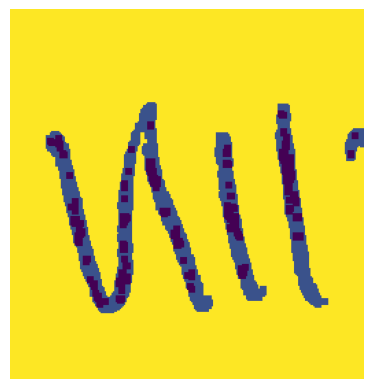

In [87]:
show_image_from_np_array(train_data['image'][18])

In [88]:
train_data.iloc[18]

image        [[255, 255, 255, 255, 255, 255, 255, 255, 255,...
label                                                     VIII
uid                       c776dc0b-deb2-4d96-bc4a-8aee0d4296ed
class_idx                                                    4
Name: 18, dtype: object

In [ ]:
final_submission = train_data.copy()

In [ ]:
final_submission['is_noisy'] = False

final_submission.loc[noisy_indices, 'is_noisy'] = True

In [ ]:
print(final_submission.columns)

In [ ]:
final_submission = final_submission[['uid', 'is_noisy']]

In [ ]:
import time
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, classification_report,
    confusion_matrix, f1_score, matthews_corrcoef
)
from typing import List, Tuple

def calculate_evaluation_metrics(y_true: pd.Series, y_pred: pd.Series) -> Tuple[float, float, float, str, float, np.ndarray]:
    f1 = f1_score(y_true, y_pred, average='micro')
    balanced_accuracy = balanced_accuracy_score(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    classification_report_str = classification_report(y_true, y_pred)
    matthews_corr_coeff = matthews_corrcoef(y_true, y_pred)
    confusion_matrix_arr = confusion_matrix(y_true, y_pred)

    return f1, balanced_accuracy, accuracy, classification_report_str, matthews_corr_coeff, confusion_matrix_arr

def train_and_evaluate_logistic_regression(X_train: pd.DataFrame,
                                           y_train: pd.Series,
                                           X_valid: pd.DataFrame,
                                           y_valid: pd.Series) -> Tuple[pd.DataFrame, List[List]]:
    model_name = 'LogisticRegression'
    model = LogisticRegression(random_state=1408, n_jobs=-1, class_weight='balanced', max_iter=1000)

    evaluation_results = []
    classification_reports = []

    start_time = time.time()
    model.fit(X_train, y_train)
    predictions = model.predict(X_valid)

    f1, balanced_accuracy, accuracy, classification_report_str, matthews_corr_coeff, confusion_matrix_arr = calculate_evaluation_metrics(y_valid, predictions)
    classification_reports.append([model_name, classification_report_str, confusion_matrix_arr])

    elapsed_time = time.time() - start_time
    evaluation_results.append([model_name, f1, balanced_accuracy, accuracy, matthews_corr_coeff, elapsed_time, confusion_matrix_arr, classification_report_str])

    print(f'Name: {model_name} - F1: {f1:.4f} - BACC: {balanced_accuracy:.4f} - ACC: {accuracy:.4f} - MCC: {matthews_corr_coeff:.4f} - Elapsed: {elapsed_time:.2f}s')
    print(classification_report_str)
    print(confusion_matrix_arr)
    print('*' * 20, '\n')

    results_df = pd.DataFrame(evaluation_results, columns=['Model', 'F1', 'BACC', 'ACC', 'MCC', 'Total Time', 'Confusion Matrix', 'Classification Report'])
    results_df['Confusion Matrix'] = results_df['Confusion Matrix'].apply(str)

    return results_df, classification_reports
